# SBA Analysis - Exploratory Data Analysis

In this section, the sba dataset is explored further to start to visually identify relationships between the target feature, **MIS_Status_v2**, and the other features in the dataset. This analysis will start off with exploring if these defaults were happening in a particular region of the United States. Then, looking at a particular time as the data spans across 35 years from 1980 to 2014.

Afterwards, the analysis will continue by analyzing individual relationships between **MIS_Status_v2** and other categorical features, followed by numerical features. After that initial individual analyses, a few comparisons will be made using 

### Loading Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from scipy.stats import chi2_contingency, chi2, pointbiserialr
from library.utils import save_file
from library.functions import (groupbySummary, groupbyCounts, 
                              buildContingencyTable, computeChiSquareStatistics, computePointBiserialR)

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
loan_eda_v1 = pd.read_csv('./../data/interim/sba_national_final_ver1.csv')

### Previewing Data

In [3]:
pd.set_option('display.max_columns', None) 
loan_eda_v1.head()

,City,State,Zip,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,NAICS_sectors,isFranchise,RevLineCr_v2,LowDoc_v2,MIS_Status_v2,unemployment_rate,gdp_growth,gdp_annual_change,inflation_rate,inf_rate_annual_chg
0,EVANSVILLE,IN,47711,1997,84,4,new_business,0,0,unknown,60000.0,0.0,0.0,60000.0,48000.0,45,not_franchise,N,Y,paid,3.5,4.4472,0.67,2.3377,-0.59
1,NEW PARIS,IN,46526,1997,60,2,new_business,0,0,unknown,40000.0,0.0,0.0,40000.0,32000.0,72,not_franchise,N,Y,paid,3.5,4.4472,0.67,2.3377,-0.59
2,BLOOMINGTON,IN,47401,1997,180,7,existing_business,0,0,unknown,287000.0,0.0,0.0,287000.0,215250.0,62,not_franchise,N,N,paid,3.5,4.4472,0.67,2.3377,-0.59
3,BROKEN ARROW,OK,74012,1997,60,2,existing_business,0,0,unknown,35000.0,0.0,0.0,35000.0,28000.0,0,not_franchise,N,Y,paid,4.1,4.4472,0.67,2.3377,-0.59
4,ORLANDO,FL,32801,1997,240,14,existing_business,7,7,unknown,229000.0,0.0,0.0,229000.0,229000.0,0,not_franchise,N,N,paid,4.8,4.4472,0.67,2.3377,-0.59


In [4]:
loan_eda_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896180 entries, 0 to 896179
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   City                 896180 non-null  object 
 1   State                896180 non-null  object 
 2   Zip                  896180 non-null  int64  
 3   ApprovalFY           896180 non-null  int64  
 4   Term                 896180 non-null  int64  
 5   NoEmp                896180 non-null  int64  
 6   NewExist             896180 non-null  object 
 7   CreateJob            896180 non-null  int64  
 8   RetainedJob          896180 non-null  int64  
 9   UrbanRural           896180 non-null  object 
 10  DisbursementGross    896180 non-null  float64
 11  BalanceGross         896180 non-null  float64
 12  ChgOffPrinGr         896180 non-null  float64
 13  GrAppv               896180 non-null  float64
 14  SBA_Appv             896180 non-null  float64
 15  NAICS_sectors    

In [5]:
loan_eda_v1.describe()

,Zip,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,NAICS_sectors,unemployment_rate,gdp_growth,gdp_annual_change,inflation_rate,inf_rate_annual_chg
count,896180.000000,896180.000000,896180.000000,896180.000000,896180.000000,896180.000000,8.961800e+05,896180.000000,8.961800e+05,8.961800e+05,8.961800e+05,896180.000000,896180.000000,896180.000000,896180.000000,896180.000000,896180.000000
mean,53855.956563,2001.166085,110.825271,11.409077,8.453605,10.819210,2.016280e+05,2.999303,1.345988e+04,1.930783e+05,1.497762e+05,39.643949,5.495028,2.807210,-0.122719,2.798686,-0.000760
std,31173.027707,5.861402,78.907846,73.829659,237.080529,237.512811,2.879286e+05,1444.560884,6.512531e+04,2.835521e+05,2.286524e+05,26.270379,1.575927,1.488929,1.525482,0.930765,0.987645
min,0.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000e+00,1.000000e+03,5.000000e+02,0.000000,2.300000,-2.536800,-4.340000,-0.355500,-4.200000
25%,27612.000000,1997.000000,60.000000,2.000000,0.000000,0.000000,4.240000e+04,0.000000,0.000000e+00,3.500000e+04,2.125000e+04,23.000000,4.500000,1.876200,-0.980000,2.337700,-0.550000
50%,55416.000000,2002.000000,84.000000,4.000000,0.000000,1.000000,1.000000e+05,0.000000,0.000000e+00,9.000000e+04,6.200000e+04,44.000000,5.300000,2.861200,-0.290000,2.852700,0.130000
75%,83706.000000,2006.000000,120.000000,10.000000,1.000000,4.000000,2.390000e+05,0.000000,0.000000e+00,2.250000e+05,1.750000e+05,56.000000,6.200000,3.798900,0.940000,3.225900,0.680000
max,99999.000000,2014.000000,569.000000,9999.000000,8800.000000,9500.000000,1.144632e+07,996262.000000,3.512596e+06,5.472000e+06,5.472000e+06,92.000000,17.800000,7.236600,6.390000,13.549200,2.290000


### Target Feature - MIS_Status_v2

**MIS_Status_v2** provides the information on if the loan applicant paid or defaulted on their loan. This initial analysis looks at how many loans are default in the dataset.

In [6]:
loan_eda_v1['MIS_Status_v2'].value_counts()

paid       739551
default    156629
Name: MIS_Status_v2, dtype: int64

In [7]:
loan_eda_v1['MIS_Status_v2'].value_counts(normalize=True)

paid       0.825226
default    0.174774
Name: MIS_Status_v2, dtype: float64

Only 17.48% of the loans defaulted; therefore, this dataset has a **class imbalance**. If the model for this analysis assumes that no loan defaults, the model would have an accuracy of 82.5%. The model would be 100% correct on predicting loans that don't default, but 0% correct on predicting defaulted loans. Therefore, some useful metrics such as precision, recall, and/or F-Score will need to be leveraged to help determine the effectiveness of the final model.

## Exploring The Data

### Comparing State Data

In [8]:
state_data = loan_eda_v1.groupby('State')['MIS_Status_v2'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

In [9]:
state_default = state_data[state_data['MIS_Status_v2'] == 'default']
state_default[state_default['percent'] > 17.48]

,State,MIS_Status_v2,percent
7,AZ,default,20.714124
9,CA,default,18.469643
11,CO,default,17.710258
15,DC,default,23.803605
17,DE,default,17.974453
19,FL,default,27.332346
21,GA,default,23.938918
29,IL,default,22.508975
31,IN,default,17.530759
35,KY,default,19.289143


There are definitely some states that are much higher than the average value of 17.48%. A visual of the United States with this information is displayed below.

In [10]:
states = gpd.read_file('../data/external/States_shapefile-shp/States_shapefile.shp')

In [11]:
states = states.merge(state_default, left_on='State_Code', right_on='State', how='left')

In [12]:
states.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,State,MIS_Status_v2,percent
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",AL,default,16.524967
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",AK,default,11.366486
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",AZ,default,20.714124
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",AR,default,16.685118
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",CA,default,18.469643


In [13]:
states2 = states[(states['State_Name'] != 'ALASKA') & (states['State_Name'] != 'HAWAII')]

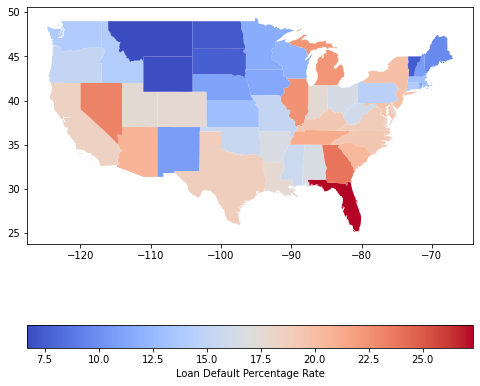

In [14]:
states2.plot(figsize=(8,10), cmap='coolwarm', column='percent', legend=True, 
             legend_kwds={'orientation': 'horizontal', 'label': 'Loan Default Percentage Rate'})
plt.show()

This graph is very revealing. Some states (i.e. Florida, Georgia) or even geographic regions (i.e. southeast) are much more susceptible to defaulting on their loans than other areas of the country. This feature is likely an influencing component to identifying high risk loan applicants.

### Annual Analysis of MIS_Status

Looking at the distribution of defaults through an annual analysis may reveal some specific time periods where the economy was struggling, and thus would be a time banks would need to be more strict on approving loans.

In [17]:
annual_analysis = groupbyCounts(loan_eda_v1, 'MIS_Status_v2', 'ApprovalFY')

## Just showing the years where the default rate was higher than the average
annual_analysis[(annual_analysis['MIS_Status_v2'] == 'default') & (annual_analysis['percent'] > 17.48)]

,ApprovalFY,MIS_Status_v2,percent
0,1980,default,96.247241
2,1981,default,71.000000
5,1982,default,42.420028
7,1983,default,31.747919
9,1984,default,36.948985
11,1985,default,40.443071
13,1986,default,40.840415
15,1987,default,43.507665
17,1988,default,49.393780
49,2004,default,18.045311


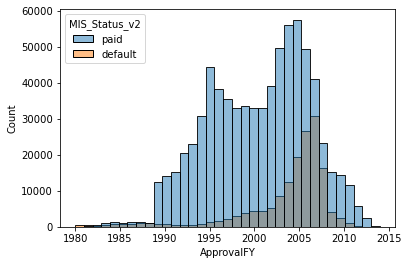

In [30]:
### Looking at all of this data as a  histogram
fig, ax = plt.subplots()
g = sns.histplot(x='ApprovalFY',
                 hue='MIS_Status_v2',
                 data=loan_eda_v1,
                 bins=35
                )
sns.move_legend(g, 'upper left')
plt.show()

Definitely two specific time periods where small businesses struggled to pay off their loans (1980-1988) and (2004-2009). In both of these periods, there were recessions that hit the United States economy. There were two separate recessions from 1980-1982, and the second recession had a peak unemployment near 11%. (**place citation here**) The second time period had The Great Recession where the GDP suffered over 5% decrease and a 10% unemployment rate (**place citation here**). This is encouraging for some of the other national metrics that were included in this analysis as they may be strong indicators for identifying high risk applicants.

In the histogram, banks were very conservative in passing out this loan, as they should have been with so many defaulting. The graph shows a boom of approvals in 1989, which is the first year in the 1980s where the default rate did not exceed the oveall average. The defaults rapidly increase in the 2000s and peak in 2007 which was the start of the Great Recession. 

This is another note to make, and it may be worth adding an *isRecession* feature to the dataset to weigh against the other features.

### MIS_Status_v2 compared to other categorical features

In [44]:
def create_thresholds(data, threshold):
    """
    Takes in created dataframe from group by counts and returns dataframe with two new columns, above threshold 
    and below threshold, so data will be easier to interpret in the bar chart. Returned dataframe focuses on 
    defaulted data only.
    """
    defaulted_data = data[data['MIS_Status_v2'] == 'default']
    defaulted_data['above_threshold'] = np.maximum(defaulted_data['percent'] - threshold, 0)
    defaulted_data['below_threshold'] = np.minimum(defaulted_data['percent'], threshold)
    
    return defaulted_data

In [60]:
def create_barplots(df, columns, ncol=None, figsize=(20,10), threshold=17.48):
    """
    Takes a list of features (columns), and will create a bar graph for each feature. The bar graph is set up to
    show a threshold line where everything below the threshold will be green and everything above the threshold will
    be red. This allows for quick visualizations of different outcomes that exceed the target threshold.
    """
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize = figsize, squeeze = False)
    for i, col in enumerate(columns):
        data = groupbyCounts(df, 'MIS_Status_v2', col)
        defaulted_data = create_thresholds(data, threshold)
        ax = axes.flatten()[i]
        ax.bar(defaulted_data[col], defaulted_data['below_threshold'], 0.5, color='g')
        ax.bar(defaulted_data[col], defaulted_data['above_threshold'], 0.5, 
               color='r', bottom=defaulted_data['below_threshold'])
        ax.axhline(threshold, color='b')
        ax.set(xlabel=col, ylabel='Percent Default')

In [53]:
categoricalFeatures = ['NewExist', 'UrbanRural', 'NAICS_sectors', 'isFranchise', 'RevLineCr_v2', 'LowDoc_v2']

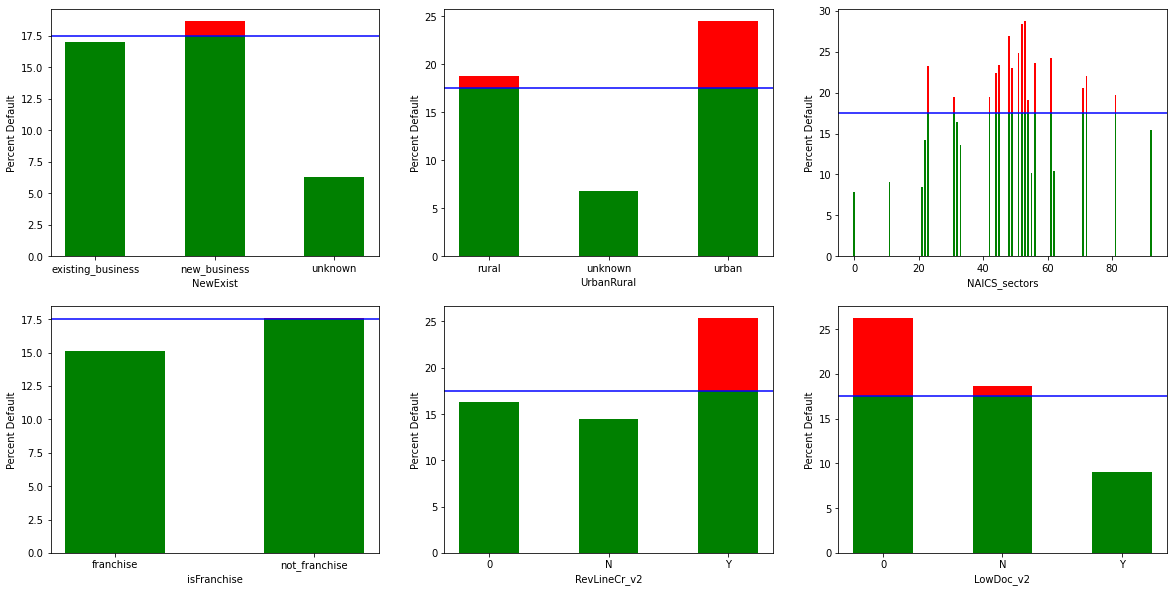

In [62]:
create_barplots(loan_eda_v1, categoricalFeatures, ncol=3)

This graph reveals a few features that do have classes where the default rate is much higher than the average. It seems those that are in urban settings and take out a revolving line of credit were a bit more susceptible to default. The LowDoc feature will be hard to analyze further. The "0" is all of the undefined data points. There were many different values that were populated there, but those meanings are unknown; thus, they were reclassified to "0". While the value seems as significant as others. That value will be hard to continue to analyze going forward because the meanings of the various values are unknown.

The NAICS sectors graph is harder to read. A frequency distribution chart for those values are printed below.

In [59]:
naics_observations = groupbyCounts(loan_eda_v1, 'MIS_Status_v2', 'NAICS_sectors')
naics_defaults = naics_observations[naics_observations['MIS_Status_v2'] == 'default']

naics_defaults.sort_values('percent', ascending=False)

,NAICS_sectors,MIS_Status_v2,percent
31,53,default,28.731233
29,52,default,28.426610
23,48,default,26.888801
27,51,default,24.828375
39,61,default,24.246212
37,56,default,23.551293
21,45,default,23.415393
9,23,default,23.255429
25,49,default,22.986425
19,44,default,22.394078


Based on the [data-dictionary](../references/data_dictionary.md), the sectors with the highest default rates are Real Estate (53), Finance and Insurance (52), and Transportation/warehousing(48). The next two highest are Information and Education; therefore, these defaults are occurring across a wide array of industries. 

Knowing a higher proportion of defaults occurred with applications between 2004 and 2009, below is the percentages for which industries defaulted the most during that time period.

In [64]:
great_recession_data = loan_eda_v1[(loan_eda_v1['ApprovalFY'] >= 2004) & (loan_eda_v1['ApprovalFY'] <= 2009)]
naics_2000s_obs = groupbyCounts(great_recession_data, 'MIS_Status_v2', 'NAICS_sectors')

naics_2000s_defaults = naics_2000s_obs[naics_2000s_obs['MIS_Status_v2'] == 'default']

naics_2000s_defaults.sort_values('percent', ascending=False)

,NAICS_sectors,MIS_Status_v2,percent
30,53,default,39.404472
28,52,default,38.185226
20,45,default,36.280536
26,51,default,35.435481
22,48,default,35.039223
8,23,default,34.664602
48,92,default,34.210526
18,44,default,33.853220
34,55,default,33.802817
16,42,default,33.557728


The 2000s recession definitely did not pick on one industry as all industries are very elevated during this period. Only two industries (Agriculture and Mining) remained below the overall average. 

One more quick analysis before moving onto the numerical features, both urban and revolving line of credit outcomes had a higher than average percentage. Below is a total count of the number of applicants that paid and defaulted from 2004-2009 that were in an urban setting with a revolving line of credit. There is also a percentage distribution of defaults by year.

In [68]:
gr_urb_rlc_data = great_recession_data[(great_recession_data['RevLineCr_v2'] == 'Y') 
                                       & (great_recession_data['UrbanRural'] == 'urban')]

gr_urb_rlc_data['MIS_Status_v2'].value_counts()

paid       78040
default    37837
Name: MIS_Status_v2, dtype: int64

In [66]:
gr_urb_rlc_obs = groupbyCounts(gr_urb_rlc_data, 'MIS_Status_v2', 'ApprovalFY')
gr_urb_rlc_default = gr_urb_rlc_obs[gr_urb_rlc_obs['MIS_Status_v2'] == 'default']

gr_urb_rlc_default.sort_values('percent', ascending=False)

,ApprovalFY,MIS_Status_v2,percent
9,2008,default,44.946614
7,2007,default,44.565847
5,2006,default,35.348975
3,2005,default,24.705934
11,2009,default,18.042682
1,2004,default,16.676608


Definitely getting closer to identifing some key factors into identifying high risks applicants. The Great Recession started in 2007 and ending in 2009. Therefore, seeing the default rates in mid 40 percentile is definitely valuable information.

### MIS_Status_v2 compared to other numerical features